# CNV Analysis

In [1]:
import cPickle
import datetime
import glob
import os
import random
import re
import subprocess

import cdpybio as cpb
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline

dy_name = 'cnv_analysis'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
transcript_to_gene = pd.read_table(cpy.gencode_transcript_gene, header=None, 
                                   squeeze=True, index_col=0)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
exp = pd.read_table(fn, index_col=0)

dy = os.path.join(ciepy.root, 'output/eqtl_processing/eqtls01')
fn = os.path.join(dy, 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)
fn = os.path.join(dy, 'lead_variants.tsv')
lead_vars = pd.read_table(fn, index_col=0)
fn = os.path.join(dy, 'lead_variants_single.tsv')
lead_vars_single = pd.read_table(fn, index_col=0)
fn = os.path.join(dy, 'gene_variant_pairs.tsv')
gene_variant = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output/cnv_processing/cnv_info.tsv')
cnv_info = pd.read_table(fn, index_col=0)

gene_bt = pbt.BedTool(cpy.gencode_gene_bed)

fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'encode_dnase_overlap.tsv')
encode_dnase_overlap = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'encode_tf_chip_seq_overlap.tsv')
encode_chip_overlap = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'roadmap_overlap.tsv')
roadmap_overlap = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'private_output', 'cnv_processing', 'emmax_cnvs.tsv')
emmax_cnvs = pd.read_table(fn, index_col=0)

In [3]:
cnv_lead_vars = lead_vars[lead_vars.variant_type == 'cnv']
cnv_gv = gene_variant[gene_variant.variant_type == 'cnv']
cnv_gv['cnv_id'] = cnv_gv.marker_id.apply(lambda x: 'CNV' + x.split('CNV')[1])

In [84]:
n = emmax_cnvs.shape[0]
print('{:,} distinct CNVs we could test'.format(n))
a = cnv_lead_vars.shape[0]
b = len(set(cnv_lead_vars.marker_id))
print('{} eQTLs with CNV as lead variant ({} distinct CNVs)'.format(a, b))
a = cnv_gv.shape[0]
b = len(set(cnv_gv.gene_id))
c = len(set(cnv_gv.marker_id))
print('{:,} gene-CNV associations for {} genes and {} CNVs'.format(a, b, c))

3,222 distinct CNVs we could test
158 eQTLs with CNV as lead variant (135 distinct CNVs)
1,043 gene-CNV associations for 306 genes and 524 CNVs


In [5]:
cnv_gv['cnv_is_lead'] = cnv_gv.gene_id.apply(lambda x: x in cnv_lead_vars.gene_id.values)
lead_vars['cnv_is_lead'] = lead_vars.gene_id.apply(lambda x: x in cnv_lead_vars.gene_id.values)
lead_vars['cnv_sig'] = lead_vars.gene_id.apply(lambda x: x in cnv_gv.gene_id.values)

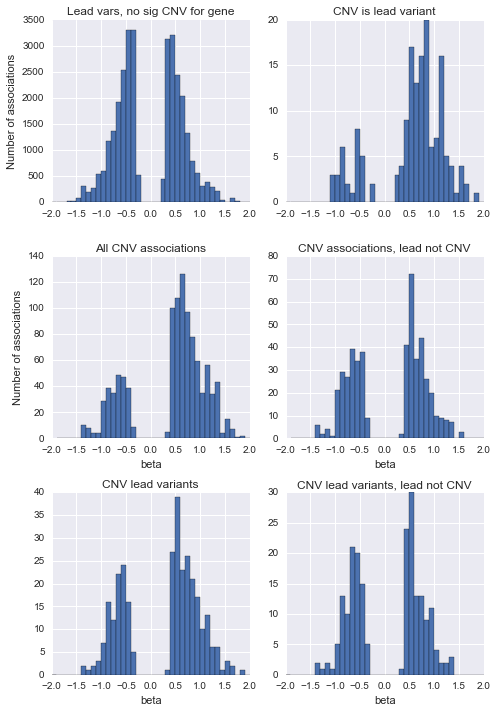

In [6]:
fig,axs = plt.subplots(3, 2, figsize=(7, 10))
ax = axs[0, 0]
lead_vars[lead_vars.cnv_sig == False].beta.hist(ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_ylabel('Number of associations')
ax.set_title('Lead vars, no sig CNV for gene')
ax = axs[0, 1]
cnv_lead_vars.beta.hist(ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_title('CNV is lead variant')
ax = axs[1, 0]
cnv_gv.beta.hist(ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_ylabel('Number of associations')
ax.set_xlabel('beta')
ax.set_title('All CNV associations')
ax = axs[1, 1]
cnv_gv[cnv_gv.cnv_is_lead == False].beta.hist(ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_xlabel('beta')
ax.set_title('CNV associations, lead not CNV')
ax = axs[2, 0]
cnv_gv.sort_values('pvalue').drop_duplicates('gene_id').beta.hist(ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_xlabel('beta')
ax.set_title('CNV lead variants')
ax = axs[2, 1]
cnv_gv[cnv_gv.cnv_is_lead == False].sort_values('pvalue').drop_duplicates('gene_id').beta.hist(
    ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_xlabel('beta')
ax.set_title('CNV lead variants, lead not CNV')
plt.tight_layout()

In [86]:
s,p = stats.mannwhitneyu(lead_vars[lead_vars.cnv_sig == False].beta,
                         cnv_lead_vars.beta)
print(p)
s,p = stats.mannwhitneyu(lead_vars[lead_vars.cnv_sig == False].beta,
                         cnv_gv.beta)
print(p)
s,p = stats.mannwhitneyu(cnv_gv[cnv_gv.cnv_is_lead == False].beta,
                         cnv_gv.beta)
print(p)
s,p = stats.mannwhitneyu(lead_vars[lead_vars.cnv_sig == False].beta,
                         cnv_gv.sort_values('pvalue').drop_duplicates('gene_id').beta)
print(p)
s,p = stats.mannwhitneyu(lead_vars[lead_vars.cnv_sig == False].beta,
                         cnv_gv[cnv_gv.cnv_is_lead == False].sort_values('pvalue').drop_duplicates('gene_id').beta)
print(p)

1.20347528316e-26
1.31774279015e-93
4.90050044004e-14
1.18355333345e-12
0.0511360573928


In [8]:
sig_cnvs = set(cnv_gv.cnv_id)
not_sig_cnvs = set(emmax_cnvs.index) - sig_cnvs

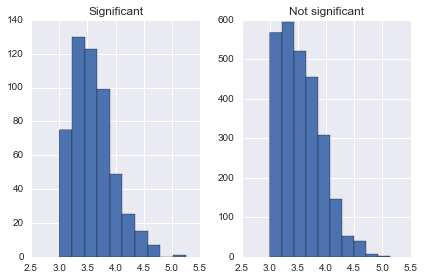

In [9]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
np.log10(cnv_info.ix[sig_cnvs, 'length']).hist(ax=ax)
ax.set_title('Significant')
ax = axs[1]
np.log10(cnv_info.ix[not_sig_cnvs, 'length']).hist()
ax.set_title('Not significant');
plt.tight_layout()

In [10]:
s,p = stats.mannwhitneyu(cnv_info.ix[sig_cnvs, 'length'], 
                         cnv_info.ix[not_sig_cnvs, 'length'])
print(p)

0.00245510770335


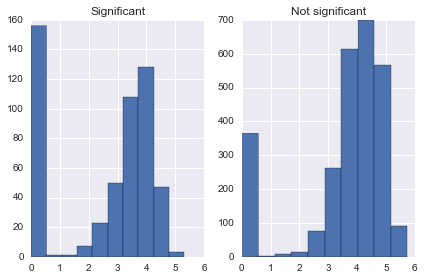

In [11]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
np.log10(cnv_info.ix[sig_cnvs, 'nearest_tss_dist'].abs() + 1).hist(ax=ax)
ax.set_title('Significant')
ax = axs[1]
np.log10(cnv_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs() + 1).hist()
ax.set_title('Not significant');
plt.tight_layout()

In [40]:
a = cnv_info.ix[sig_cnvs, 'nearest_tss_dist'].abs()
a = a[a != 0]
b = cnv_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs()
b = b[b != 0]
s,p = stats.mannwhitneyu(a, b)
print(p)

1.74681689429e-41


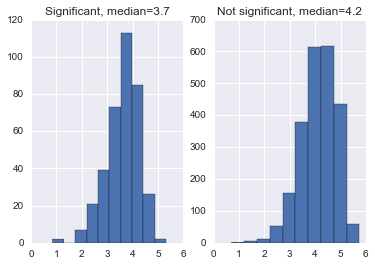

In [41]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
np.log10(a.abs()).hist(ax=ax)
ax.set_title('Significant, median={:.1f}'.format(np.log10(a.abs()).median()))
ax = axs[1]
ax.set_title('Not significant, median={:.1f}'.format(np.log10(b.abs()).median()))
np.log10(b.abs()).hist(ax=ax);

We can see that significant CNVs are typically closer to a TSS than CNVs
that are not signficant.

In [43]:
a = cnv_info.ix[sig_cnvs - set(cnv_gv.ix[cnv_gv.cnv_overlaps_gene, 'cnv_id']), 'nearest_tss_dist'].abs()
a = a[a != 0]
b = cnv_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs()
b = b[b != 0]
s,p = stats.mannwhitneyu(a, b)
print(p)

4.78205586884e-33


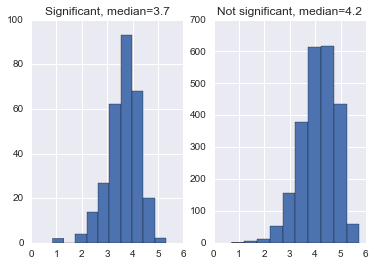

In [44]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
np.log10(a.abs()).hist(ax=ax)
ax.set_title('Significant, median={:.1f}'.format(np.log10(a.abs()).median()))
ax = axs[1]
ax.set_title('Not significant, median={:.1f}'.format(np.log10(b.abs()).median()))
np.log10(b.abs()).hist(ax=ax);

Even if we remove CNVs that overlap genes, the significant
CNVs are still closer to genes.

In [14]:
s = '\n'.join(cnv_info.chrom + '\t' + cnv_info.start.astype(str) + 
              '\t' + cnv_info.end.astype(str) + '\t' + cnv_info.name) + '\n'
cnv_bt = pbt.BedTool(s, from_string=True)
cnv_bt = cnv_bt.sort()

In [15]:
res = cnv_bt.intersect(gene_bt, sorted=True, wo=True)
df = res.to_dataframe()
overlaps_gene = set(df.name)

In [16]:
overlaps_sig = len(sig_cnvs & overlaps_gene)
overlaps_not_sig = len(not_sig_cnvs & overlaps_gene)
no_overlaps_sig = len(sig_cnvs) - overlaps_sig
no_overlaps_not_sig = len(not_sig_cnvs) - overlaps_not_sig
ctable = [[overlaps_sig, overlaps_not_sig], 
          [no_overlaps_sig, no_overlaps_not_sig]]
odds,p = stats.fisher_exact(ctable)
print('CNVs with significant association are enriched for '
      'overlapping a gene p={:.1e}'.format(p))

CNVs with significant association are enriched for overlapping a gene p=5.4e-20


In [17]:
cnv_gv['cnv_gene'] = cnv_gv.cnv_id + ':' + cnv_gv.gene_id
t = pd.DataFrame(True, index=df.name + ':' + df.thickEnd, columns=['cnv_overlaps_gene'])
cnv_gv = cnv_gv.merge(t, left_on='cnv_gene', right_index=True, how='left')
cnv_gv.ix[cnv_gv.cnv_overlaps_gene.isnull(), 'cnv_overlaps_gene'] = False

I'm going to look at CNV-eQTLs where the CNV doesn't overlap the affected gene.

In [18]:
s = set(cnv_gv.ix[cnv_gv.cnv_overlaps_gene, 'gene_id'])
intergenic_cnv_gv = cnv_gv[cnv_gv.gene_id.apply(lambda x: x not in s)]

In [19]:
sig_intergenic_cnvs = set(intergenic_cnv_gv.cnv_id)
not_sig_cnvs = set(emmax_cnvs.index) - set(cnv_gv.cnv_id)

In [20]:
overlaps_sig = len(sig_intergenic_cnvs & overlaps_gene)
overlaps_not_sig = len(not_sig_cnvs & overlaps_gene)
no_overlaps_sig = len(sig_intergenic_cnvs) - overlaps_sig
no_overlaps_not_sig = len(not_sig_cnvs) - overlaps_not_sig
ctable = [[overlaps_sig, overlaps_not_sig], 
          [no_overlaps_sig, no_overlaps_not_sig]]
odds,p = stats.fisher_exact(ctable)
print('CNVs with significant association are enriched for '
      'overlapping a gene p={:.1e}'.format(p))

CNVs with significant association are enriched for overlapping a gene p=1.2e-08


While these CNVs don't overlap the gene that they are an eQTL for, they are still
enriched for overlapping some other gene.

In [21]:
odds = []
pvalues = []
for c in roadmap_overlap.columns:
    vc = (roadmap_overlap.ix[sig_intergenic_cnvs, c] > 0).value_counts()
    sig_overlap = vc[True]
    sig_not_overlap = vc[False]
    vc = (roadmap_overlap.ix[not_sig_cnvs, c] > 0).value_counts()
    not_sig_overlap = vc[True]
    not_sig_not_overlap = vc[False]
    ctable = [[sig_overlap, sig_not_overlap], 
              [not_sig_overlap, not_sig_not_overlap]]
    o,p = stats.fisher_exact(ctable)
    odds.append(o)
    pvalues.append(p)
roadmap_res = pd.DataFrame({'odds':odds, 'pvalue':pvalues}, index=roadmap_overlap.columns)
colors = pd.DataFrame(zip(list(set([x.split('_')[-1] for x in roadmap_res.index])), 
                          cpb.analysis.tableau20[::2]), columns=['mark', 'color'])
roadmap_res['mark'] = [x.split('_')[-1] for x in roadmap_res.index]
roadmap_res['ind'] = roadmap_res.index
roadmap_res = roadmap_res.merge(colors)
roadmap_res.index = roadmap_res.ind

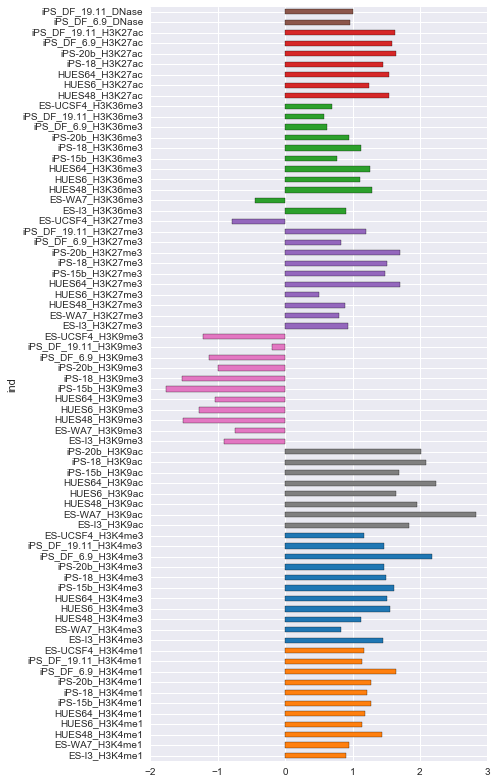

In [22]:
plt.figure(figsize=(7, 11))
(np.log2(roadmap_res.odds)).plot(kind='barh', color=roadmap_res.color)
plt.tight_layout()

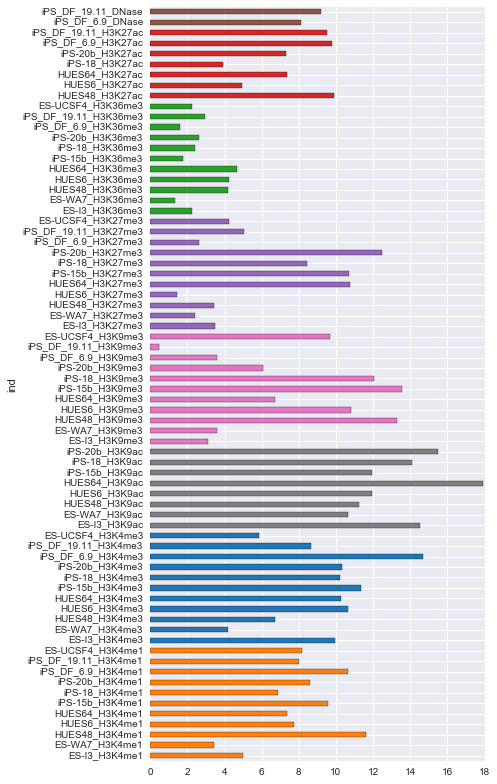

In [23]:
plt.figure(figsize=(7, 11))
(-np.log10(roadmap_res.pvalue)).plot(kind='barh', color=roadmap_res.color)
plt.tight_layout()

In [24]:
odds = []
pvalues = []
for c in encode_dnase_overlap.columns:
    vc = (encode_dnase_overlap.ix[sig_intergenic_cnvs, c] > 0).value_counts()
    sig_overlap = vc[True]
    sig_not_overlap = vc[False]
    vc = (encode_dnase_overlap.ix[not_sig_cnvs, c] > 0).value_counts()
    not_sig_overlap = vc[True]
    not_sig_not_overlap = vc[False]
    ctable = [[sig_overlap, sig_not_overlap], 
              [not_sig_overlap, not_sig_not_overlap]]
    o,p = stats.fisher_exact(ctable)
    odds.append(o)
    pvalues.append(p)
encode_dnase_res = pd.DataFrame({'odds':odds, 'pvalue':pvalues}, index=encode_dnase_overlap.columns)

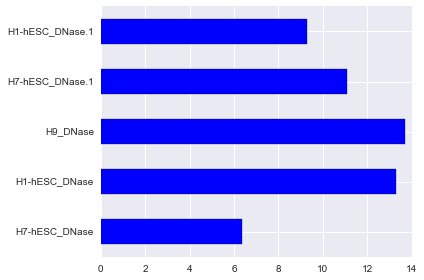

In [25]:
(-np.log10(encode_dnase_res.pvalue)).plot(kind='barh')
plt.tight_layout()

In [26]:
odds = []
pvalues = []
for c in encode_chip_overlap.columns:
    vc = (encode_chip_overlap.ix[sig_intergenic_cnvs, c] > 0).value_counts()
    if True not in vc.index:
        sig_overlap = 0
    else:
        sig_overlap = vc[True]
    sig_not_overlap = vc[False]
    vc = (encode_chip_overlap.ix[not_sig_cnvs, c] > 0).value_counts()
    if True not in vc.index:
        not_sig_overlap = 0
    else:
        not_sig_overlap = vc[True]
    not_sig_not_overlap = vc[False]
    ctable = [[sig_overlap, sig_not_overlap], 
              [not_sig_overlap, not_sig_not_overlap]]
    o,p = stats.fisher_exact(ctable)
    odds.append(o)
    pvalues.append(p)
encode_chip_res = pd.DataFrame({'odds':odds, 'pvalue':pvalues}, index=encode_chip_overlap.columns)
encode_chip_res.sort_values(by='pvalue', inplace=True, ascending=False)

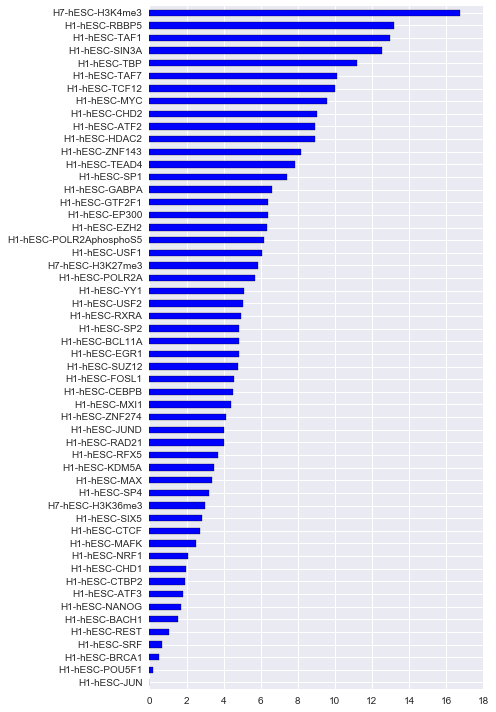

In [32]:
plt.figure(figsize=(7, 10))
(-np.log10(encode_chip_res.pvalue)).plot(kind='barh')
plt.tight_layout()

In [93]:
lead_vars[lead_vars.variant_type == 'del']

,chrom,start,end,marker_id,ns,ac,callrate,genocnt,maf,stat,...,length,tss_dist,tss_dist_abs,gene_name,gene_type,perm_pvalue,perm_qvalue,perm_sig,cnv_is_lead,cnv_sig
chr1:24704498-24704502:ENSG00000001460.13,chr1,24704498,24704502,1:24704499_ATCC/A_rs66955913,215,131,1.00000,108/83/24,0.30465,-4.0711,...,3,1811,1811,STPG1,protein_coding,0.046953,0.055189,False,False,False
chr7:91989387-91989389:ENSG00000001630.11,chr7,91989387,91989389,7:91989388_AT/A_rs149922393,215,34,1.00000,181/34/0,0.07907,-3.6364,...,1,-217122,217122,CYP51A1,protein_coding,0.142857,0.124967,False,False,False
chr7:127092456-127092463:ENSG00000004059.6,chr7,127092456,127092463,7:127092457_GAGTAAA/G_rs147892816,215,34,1.00000,182/32/1,0.07907,3.4024,...,6,-135936,135936,ARF5,protein_coding,0.276723,0.189541,False,False,False
chr7:127109323-127109327:ENSG00000004059.6,chr7,127109323,127109327,7:127109324_TATG/T_rs148377495,215,34,1.00000,182/32/1,0.07907,3.4024,...,3,-119072,119072,ARF5,protein_coding,0.276723,0.189541,False,False,False
chr7:127144505-127144507:ENSG00000004059.6,chr7,127144505,127144507,7:127144506_TA/T_rs35809733,215,34,1.00000,182/32/1,0.07907,3.4024,...,1,-83892,83892,ARF5,protein_coding,0.276723,0.189541,False,False,False
chr7:127147598-127147603:ENSG00000004059.6,chr7,127147598,127147603,7:127147599_AAAAC/A_rs143817450,215,34,1.00000,182/32/1,0.07907,3.4024,...,4,-80796,80796,ARF5,protein_coding,0.276723,0.189541,False,False,False
chr17:26707062-26707064:ENSG00000004139.9,chr17,26707062,26707064,17:26707063_AT/A_rs375521295,210,56,0.97674,162/40/8,0.13333,4.7497,...,1,-4625,4625,SARM1,protein_coding,0.002020,0.003905,True,False,False
chr4:111021291-111021307:ENSG00000005059.11,chr4,111021291,111021307,4:111021292_CTGGCCATATTTATAA/C_rs33983780,215,90,1.00000,135/70/10,0.20930,3.2367,...,15,415696,415696,CCDC109B,protein_coding,0.567433,0.286928,False,False,False
chr7:102487653-102487655:ENSG00000005075.11,chr7,102487653,102487655,7:102487654_GA/G_rs200296509,215,68,1.00000,149/64/2,0.15814,3.3643,...,1,-368300,368300,POLR2J,protein_coding,0.350649,0.217911,False,False,False
chr9:34459431-34459436:ENSG00000005238.15,chr9,34459431,34459436,9:34459432_TTTTC/T,215,33,1.00000,185/27/3,0.07674,-2.8563,...,4,651984,651984,FAM214B,protein_coding,0.836164,0.355420,False,False,False


## Rare CNVs

In [62]:
fn = os.path.join(ciepy.root, 'output/cnv_processing/cnv_info.tsv')
cnv_info = pd.read_table(fn, index_col=0)

In [54]:
se = cnv_info.ix[set(cnv_gv.cnv_id), 'unrelated_percent_diff_from_mode']

In [60]:
se[se < 0.01]

CNV_2_230877094_230879627    0.008475
Name: unrelated_percent_diff_from_mode, dtype: float64

In [59]:
cnv_info.percent_diff_from_mode[se[se < 0.05].index]

CNV_1_144033903_144037975    0.047445
CNV_9_40791204_40795671      0.054745
CNV_1_144001465_144003124    0.054745
CNV_9_40782926_40789075      0.051095
CNV_12_63935898_64112662     0.051095
CNV_9_40748713_40751962      0.065693
CNV_2_230877094_230879627    0.058394
Name: percent_diff_from_mode, dtype: float64

In [63]:
cnv_info.ix['CNV_2_230877094_230879627']

chrom                                                                                  chr2
start                                                                             230877094
end                                                                               230879627
length                                                                                 2533
name                                                              CNV_2_230877094_230879627
gene_overlaps                                                             ENSG00000153832.7
nearest_tss_dist                                                                     -39064
CALLRATE                                                                              0.996
CNMIN                                                                                     1
CNMAX                                                                                     3
CNALLELES                                                                       

In [73]:
cnv_info_f = cnv_info[cnv_info.diff_from_mode != 0]

In [74]:
fams = [
    'abb401f1-5c3e-48ed-8c55-839ce2afe7e6_14_diff_from_mode',
    '84fda65d-9a06-4bbe-ad75-a24773724c32_11_diff_from_mode',
    'a56f620d-82e4-4963-a80b-b97c091c4b06_9_diff_from_mode',
    '319aca18-4ca4-444d-80ca-3c0065169793_5_diff_from_mode',
    'cec0061a-f86c-4d8f-979f-3c6edce2d905_5_diff_from_mode',
    '0a78a1f4-540f-4f63-acd1-197228abad11_5_diff_from_mode',
    '24bb1db3-75fb-4c66-9ccd-8e98dc3fadf1_5_diff_from_mode',
    ]
for fam in fams:
    se = cnv_info_f.diff_from_mode == cnv_info_f[c]
    print(se[se])

Series([], dtype: bool)
Series([], dtype: bool)
Series([], dtype: bool)
Series([], dtype: bool)
Series([], dtype: bool)
Series([], dtype: bool)
Series([], dtype: bool)


In [69]:
cnv_info.diff_from_mode.value_counts()

1      5803
2      2224
3       982
4       546
5       362
6       247
7       175
8       138
122     119
10       98
11       92
9        83
123      82
12       74
13       74
15       69
121      69
14       58
16       54
18       53
17       53
24       48
136      48
19       44
28       43
21       43
177      41
125      41
20       40
124      40
       ... 
110       4
171       4
215       3
175       3
208       3
200       3
186       3
196       3
201       2
198       2
190       2
166       2
197       2
193       2
207       2
178       2
170       2
217       2
195       1
172       1
188       1
189       1
202       1
205       1
194       1
192       1
233       1
206       1
199       1
211       1
Name: diff_from_mode, dtype: int64

In [72]:
se

CNV_1_55176_56686          False
CNV_1_85392_86406          False
CNV_1_86407_91299          False
CNV_1_562952_567683        False
CNV_1_565576_567883        False
CNV_1_565853_567683        False
CNV_1_712526_731595        False
CNV_1_746778_748786        False
CNV_1_755023_757122        False
CNV_1_755423_757622        False
CNV_1_756023_760884        False
CNV_1_758123_764307        False
CNV_1_766325_769070        False
CNV_1_776649_791838        False
CNV_1_785011_787377        False
CNV_1_1082001_1083000      False
CNV_1_1379529_1393769      False
CNV_1_1443543_1445749      False
CNV_1_1519579_1524100      False
CNV_1_1521643_1524300      False
CNV_1_1570594_1576585      False
CNV_1_1571775_1573069      False
CNV_1_1572970_1576685      False
CNV_1_1582318_1588385      False
CNV_1_1584752_1586196      False
CNV_1_1596436_1605332      False
CNV_1_1596736_1597735      False
CNV_1_1620648_1623076      False
CNV_1_1624690_1629076      False
CNV_1_1634955_1636249      False
          

In [68]:
cnv_info.ix['CNV_1_144589274_144598121']

chrom                                                                                  chr1
start                                                                             144589274
end                                                                               144598121
length                                                                                 8847
name                                                              CNV_1_144589274_144598121
gene_overlaps                                                             ENSG00000225241.3
nearest_tss_dist                                                                          0
CALLRATE                                                                                  1
CNMIN                                                                                     4
CNMAX                                                                                     4
CNALLELES                                                                       

In [67]:
se[se]

CNV_1_144589274_144598121    True
CNV_1_144837857_144847815    True
CNV_1_144847816_144852305    True
CNV_1_144854394_144894636    True
CNV_1_144907307_144909379    True
CNV_1_149648489_149659928    True
CNV_1_149726435_149737574    True
CNV_5_175351190_175356379    True
CNV_5_175364774_175369222    True
CNV_6_57238883_57244391      True
CNV_6_57268122_57273687      True
CNV_6_57273688_57285319      True
CNV_6_57289320_57297349      True
CNV_6_57399889_57401924      True
CNV_6_57403960_57407053      True
CNV_6_57409087_57411609      True
CNV_6_57417110_57421609      True
CNV_6_57460308_57464307      True
CNV_6_57472370_57477869      True
CNV_6_57481983_57484982      True
CNV_9_140776554_140779762    True
CNV_17_21236348_21238847     True
CNV_17_21245399_21253065     True
CNV_21_14376413_14380410     True
CNV_21_14383356_14385871     True
CNV_21_14394224_14397253     True
CNV_21_14399969_14410272     True
CNV_21_14415567_14422796     True
CNV_21_14424172_14440825     True
CNV_21_1444082